# Plot census data using geopandas

In [58]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame

import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union
import h3
import base64
import urllib
import tempfile
import networkx as nx
from csv import DictReader
from itertools import groupby
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
zip_f = "nyc/tl_2020_36_tract.zip"

In [4]:
census_geo = gpd.read_file(zip_f)

In [5]:
census_geo.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,+40.6923505,-073.9973434,"POLYGON ((-74.00154 40.69279, -74.00132 40.693..."
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,+40.6917206,-073.9916018,"POLYGON ((-73.99405 40.69090, -73.99374 40.691..."
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,+40.6932903,-073.9877087,"POLYGON ((-73.99073 40.69305, -73.99045 40.693..."


In [6]:
commute = pd.read_csv('nyc/ny_commute_census_tract.csv')
commute = commute.drop(0,axis=0)

In [7]:
commute = commute.rename(columns={"FIPS": "GEOID"})

In [8]:
combined = census_geo.merge(commute, on='GEOID')

## Examining the comuting census data

## Examining the household census data

In [9]:
new_census = pd.read_csv('nyc/protected_attributes_ny_AMC2020_5year.csv', skiprows=[1])

In [10]:
census_df = pd.DataFrame()

In [11]:
pop_sex_columns = ["Total Population: Male",
                   "Total Population: Female",
                   "Total Population:"]
new_census[pop_sex_columns].info()
new_census[pop_sex_columns].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Total Population: Male    5411 non-null   int64
 1   Total Population: Female  5411 non-null   int64
 2   Total Population:         5411 non-null   int64
dtypes: int64(3)
memory usage: 126.9 KB


,Total Population: Male,Total Population: Female,Total Population:
0,890,1139,2029
1,1427,1836,3263
2,1059,1094,2153
3,1347,1669,3016
4,1287,1644,2931


In [12]:
census_df["male_population"] = new_census["Total Population: Male"] 
census_df["female_population"] = new_census["Total Population: Female"] 

In [13]:
census_df["total_population"] = new_census["Total Population:"]

In [14]:
census_df["total_population_white"] = new_census["Total Population: White Alone"] 
census_df["total_population_black"] = new_census["Total Population: Black or African American Alone"]
census_df["total_population_two_ormore_races"] = new_census["Total Population: Two or More Races"]
census_df["total_population_asian"] = new_census["Total Population: Asian Alone"] 


In [15]:
census_df["population_over_25"] = new_census["Population 25 Years and Over:"]
census_df["population_over_25_no_highschool"] = new_census["Population 25 Years and Over: Less than High School"]
census_df["population_over_25_highschool"] = new_census["Population 25 Years and Over: High School Graduate (Includes Equivalency)"] 
census_df["population_over_25_bachelor"] = new_census["Population 25 Years and Over: Bachelor's Degree"]
census_df["population_over_25_master"] = new_census["Population 25 Years and Over: Master's Degree"] 



In [16]:
census_df["households"] = new_census["Households:"]
census_df["households_0_to_50,000"] = new_census[["Households: Less than $10,000",
                                                    "Households: $10,000 to $14,999",
                                                    "Households: $15,000 to $19,999",
                                                    "Households: $20,000 to $24,999",
                                                    "Households: $25,000 to $29,999",
                                                    "Households: $30,000 to $34,999",
                                                    "Households: $35,000 to $39,999",
                                                    "Households: $40,000 to $44,999",
                                                    "Households: $45,000 to $49,999"]].sum(axis=1) 
census_df["households_over_50,000"] = new_census[["Households: $50,000 to $59,999",
                                                    "Households: $60,000 to $74,999",
                                                    "Households: $75,000 to $99,999",
                                                    "Households: $100,000 to $124,999",
                                                    "Households: $125,000 to $149,999",
                                                    "Households: $150,000 to $199,999",
                                                    "Households: $200,000 or More"]].sum(axis=1) 



In [17]:
census_df["GEOID"] = new_census["FIPS"].astype(str)

In [18]:
census_df.head().T

,0,1,2,3,4
male_population,890,1427,1059,1347,1287
female_population,1139,1836,1094,1669,1644
total_population,2029,3263,2153,3016,2931
total_population_white,481,643,86,847,1936
total_population_black,1141,2230,1968,1116,469
total_population_two_ormore_races,218,301,99,581,209
total_population_asian,99,89,0,393,257
population_over_25,1159,1906,1219,1805,2125
population_over_25_no_highschool,251,239,150,352,92
population_over_25_highschool,369,402,483,560,573


In [19]:
len(set(combined.GEOID))

5411

In [20]:
census_df.shape

(5411, 16)

In [21]:
combined = combined.merge(census_df, on="GEOID")

In [22]:
combined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5411 entries, 0 to 5410
Columns: 103 entries, STATEFP to households_over_50,000
dtypes: geometry(1), int64(17), object(85)
memory usage: 4.3+ MB


# Normalising columns

In [23]:
import seaborn as sns

```python 
corr_columns = ['Workers 16 Years and Over:',
                'Workers 16 Years and Over: Car, Truck, or Van',
                'Workers 16 Years and Over: Drove Alone',
                'Workers 16 Years and Over: Carpooled',
                'Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
                'Workers 16 Years and Over: Motorcycle',
                'Workers 16 Years and Over: Bicycle',
                'Workers 16 Years and Over: Walked',
                'Workers 16 Years and Over: Other Means',
                'Workers 16 Years and Over: Worked At Home',
                'Workers 16 Years and Over:.1',
                'Workers 16 Years and Over: Did Not Work At Home',
                'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes',
                'Workers 16 Years and Over: Worked At Home.1',
                'Average Commute to Work (In Min)', 'total_population', 'male_population',"female_population"
                'total_population_white', 'total_population_black',
                'total_population_two_ormore_races', 'total_population_asian',
                'population_over_25', 'population_over_25_no_highschool',
                'population_over_25_highschool', 'population_over_25_bachelor',
                'population_over_25_master', 'households', 'households_0_to_50,000',
                'households_over_50,000']
````


In [24]:
transport_time_cols = ['Workers 16 Years and Over:',
       'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes']
combined["Workers 16 Years and Over:"] = combined["Workers 16 Years and Over:"].astype(int)
combined[transport_time_cols] = combined[transport_time_cols].astype(int)
combined[transport_time_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 8 columns):
 #   Column                                                                 Non-Null Count  Dtype
---  ------                                                                 --------------  -----
 0   Workers 16 Years and Over:                                             5411 non-null   int64
 1   Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes  5411 non-null   int64
 2   Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes      5411 non-null   int64
 3   Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes      5411 non-null   int64
 4   Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes      5411 non-null   int64
 5   Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes      5411 non-null   int64
 6   Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes      5411 non-null   int64
 7   Workers

In [25]:

combined["comute_time_less_30min"] = combined[[
       'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes']].sum(axis=1)/combined['Workers 16 Years and Over:']
combined["comute_time_more_30min"] = combined[['Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes']].sum(axis=1)/combined['Workers 16 Years and Over:']
combined[["comute_time_less_30min", "comute_time_more_30min"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   comute_time_less_30min  5285 non-null   float64
 1   comute_time_more_30min  5285 non-null   float64
dtypes: float64(2)
memory usage: 126.8 KB


In [26]:
combined[["comute_time_less_30min", "comute_time_more_30min"]+ transport_time_cols].loc[combined[["comute_time_less_30min", "comute_time_more_30min"]].isna().any(axis=1)]

,comute_time_less_30min,comute_time_more_30min,Workers 16 Years and Over:,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes
38,NaN,NaN,0,0,0,0,0,0,0,0
68,NaN,NaN,0,0,0,0,0,0,0,0
127,NaN,NaN,0,0,0,0,0,0,0,0
133,NaN,NaN,0,0,0,0,0,0,0,0
405,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5301,NaN,NaN,0,0,0,0,0,0,0,0
5307,NaN,NaN,0,0,0,0,0,0,0,0
5352,NaN,NaN,0,0,0,0,0,0,0,0
5369,NaN,NaN,0,0,0,0,0,0,0,0


In [27]:
transport_cols = ['Workers 16 Years and Over:',
                'Workers 16 Years and Over: Car, Truck, or Van',
                'Workers 16 Years and Over: Drove Alone',
                'Workers 16 Years and Over: Carpooled',
                'Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
                'Workers 16 Years and Over: Motorcycle',
                'Workers 16 Years and Over: Bicycle',
                'Workers 16 Years and Over: Walked',
                'Workers 16 Years and Over: Other Means',
                'Workers 16 Years and Over: Worked At Home']

combined[transport_cols] = combined[transport_cols].astype(int)
combined["over_16_puplictransportation"] = combined['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'] /combined['Workers 16 Years and Over:']
combined["over_16_not_worked_home"] = combined['Workers 16 Years and Over: Worked At Home']/combined['Workers 16 Years and Over:']
combined["over_16_non_polution_transport"] = combined[['Workers 16 Years and Over: Bicycle','Workers 16 Years and Over: Walked']].sum(axis=1)/combined['Workers 16 Years and Over:']
combined["over_16_non_public_transport"] = combined[['Workers 16 Years and Over: Car, Truck, or Van',
                                                   'Workers 16 Years and Over: Drove Alone',
                                                   'Workers 16 Years and Over: Carpooled',
                                                   'Workers 16 Years and Over: Motorcycle',
                                                   'Workers 16 Years and Over: Other Means']].sum(axis=1) /combined['Workers 16 Years and Over:']

combined[["over_16_non_public_transport"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   over_16_non_public_transport  5285 non-null   float64
dtypes: float64(1)
memory usage: 84.5 KB


In [28]:
population_cols = ['male_population',
               'total_population_white', 'total_population_black',
               'total_population_two_ormore_races', 'total_population_asian',"female_population"]


combined[population_cols] = combined[population_cols].div(combined["total_population"], axis=0)

In [29]:
# 25 year cols 
education_25_cols = ['population_over_25_no_highschool',
               'population_over_25_highschool', 'population_over_25_bachelor',
               'population_over_25_master']
combined[education_25_cols] = combined[education_25_cols].div(combined["population_over_25"], axis=0)

In [30]:
# Household cols
household_cols = [ 'households_0_to_50,000',
               'households_over_50,000']
combined[household_cols] = combined[household_cols].div(combined["households"], axis=0)

In [31]:
normalized_cols = ['Average Commute to Work (In Min)',"over_16_puplictransportation",
                "over_16_not_worked_home",
                "over_16_non_polution_transport",
                "over_16_non_public_transport",
                "comute_time_less_30min",
                "comute_time_more_30min",
                 'male_population',
               'total_population_white', 'total_population_black',
               'total_population_two_ormore_races', 'total_population_asian',"female_population",
                'population_over_25_no_highschool',
               'population_over_25_highschool', 'population_over_25_bachelor',
               'population_over_25_master', 'households_0_to_50,000',
               'households_over_50,000']
combined[normalized_cols].head().T

,0,1,2,3,4
Average Commute to Work (In Min),36,29,32,30,39
over_16_puplictransportation,0.672611,0.651852,0.668067,0.5,0.606947
over_16_not_worked_home,0.138546,0.189198,0.126891,0.22973,0.0
over_16_non_polution_transport,0.137631,0.128395,0.07395,0.179834,0.268739
over_16_non_public_transport,0.102423,0.053086,0.178992,0.180873,0.248629
comute_time_less_30min,0.280293,0.382716,0.372269,0.288981,0.268739
comute_time_more_30min,0.581161,0.428086,0.50084,0.481289,0.731261
male_population,0.498846,0.485174,0.618509,0.518519,0.480373
total_population_white,0.84714,0.771594,0.701065,0.664058,0.40652
total_population_black,0.025391,0.038032,0.083222,0.104851,0.027279


In [32]:
combined[normalized_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
over_16_puplictransportation,5285.0,0.258915,0.258707,0.0,0.017826,0.158192,0.496970,1.000000
over_16_not_worked_home,5285.0,0.066065,0.057600,0.0,0.027451,0.053740,0.090563,1.000000
over_16_non_polution_transport,5285.0,0.066541,0.091792,0.0,0.010899,0.035889,0.085126,0.833333
over_16_non_public_transport,5285.0,1.208817,0.608961,0.0,0.632536,1.400913,1.767589,2.000000
comute_time_less_30min,5285.0,0.461728,0.223362,0.0,0.264269,0.448780,0.647541,1.000000
comute_time_more_30min,5285.0,0.472207,0.223623,0.0,0.286746,0.474557,0.668775,1.000000
male_population,5304.0,0.487676,0.060849,0.0,0.459979,0.487006,0.513109,1.000000
total_population_white,5304.0,0.624016,0.311514,0.0,0.352384,0.724652,0.902031,1.000000
total_population_black,5304.0,0.160862,0.236322,0.0,0.010671,0.045819,0.198446,1.000000
total_population_two_ormore_races,5304.0,0.045851,0.042526,0.0,0.015366,0.034288,0.064145,0.480000


In [33]:
combined[normalized_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Average Commute to Work (In Min)   5256 non-null   object 
 1   over_16_puplictransportation       5285 non-null   float64
 2   over_16_not_worked_home            5285 non-null   float64
 3   over_16_non_polution_transport     5285 non-null   float64
 4   over_16_non_public_transport       5285 non-null   float64
 5   comute_time_less_30min             5285 non-null   float64
 6   comute_time_more_30min             5285 non-null   float64
 7   male_population                    5304 non-null   float64
 8   total_population_white             5304 non-null   float64
 9   total_population_black             5304 non-null   float64
 10  total_population_two_ormore_races  5304 non-null   float64
 11  total_population_asian             5304 non-null   float

In [34]:
combined[normalized_cols].loc[combined[normalized_cols].isna().all(axis=1)]

,Average Commute to Work (In Min),over_16_puplictransportation,over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport,comute_time_less_30min,comute_time_more_30min,male_population,total_population_white,total_population_black,total_population_two_ormore_races,total_population_asian,female_population,population_over_25_no_highschool,population_over_25_highschool,population_over_25_bachelor,population_over_25_master,"households_0_to_50,000","households_over_50,000"
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
combined[normalized_cols].loc[combined[normalized_cols].isna().all(axis=1)]

,Average Commute to Work (In Min),over_16_puplictransportation,over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport,comute_time_less_30min,comute_time_more_30min,male_population,total_population_white,total_population_black,total_population_two_ormore_races,total_population_asian,female_population,population_over_25_no_highschool,population_over_25_highschool,population_over_25_bachelor,population_over_25_master,"households_0_to_50,000","households_over_50,000"
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
combined[normalized_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Average Commute to Work (In Min)   5256 non-null   object 
 1   over_16_puplictransportation       5285 non-null   float64
 2   over_16_not_worked_home            5285 non-null   float64
 3   over_16_non_polution_transport     5285 non-null   float64
 4   over_16_non_public_transport       5285 non-null   float64
 5   comute_time_less_30min             5285 non-null   float64
 6   comute_time_more_30min             5285 non-null   float64
 7   male_population                    5304 non-null   float64
 8   total_population_white             5304 non-null   float64
 9   total_population_black             5304 non-null   float64
 10  total_population_two_ormore_races  5304 non-null   float64
 11  total_population_asian             5304 non-null   float

In [37]:
combined[normalized_cols] = combined[normalized_cols].loc[~combined[normalized_cols].isna().any(axis=1)]

In [38]:
combined.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,population_over_25_master,households,"households_0_to_50,000","households_over_50,000",comute_time_less_30min,comute_time_more_30min,over_16_puplictransportation,over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,...,0.264824,1669,0.158179,0.841821,0.280293,0.581161,0.672611,0.138546,0.137631,0.102423
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,...,0.272213,2284,0.071804,0.928196,0.382716,0.428086,0.651852,0.189198,0.128395,0.053086
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,...,0.261142,818,0.110024,0.889976,0.372269,0.500840,0.668067,0.126891,0.073950,0.178992
3,36,047,001300,36047001300,13,Census Tract 13,G5020,S,293167,0,...,0.343075,1021,0.287953,0.712047,0.288981,0.481289,0.500000,0.229730,0.179834,0.180873
4,36,047,002000,36047002000,20,Census Tract 20,G5020,S,154138,0,...,0.000000,388,0.577320,0.422680,0.268739,0.731261,0.606947,0.000000,0.268739,0.248629


In [39]:
combined['over_16_puplictransportation'].describe()

count    5241.000000
mean        0.258806
std         0.257479
min         0.000000
25%         0.018153
50%         0.159873
75%         0.496673
max         0.925049
Name: over_16_puplictransportation, dtype: float64

<AxesSubplot:>

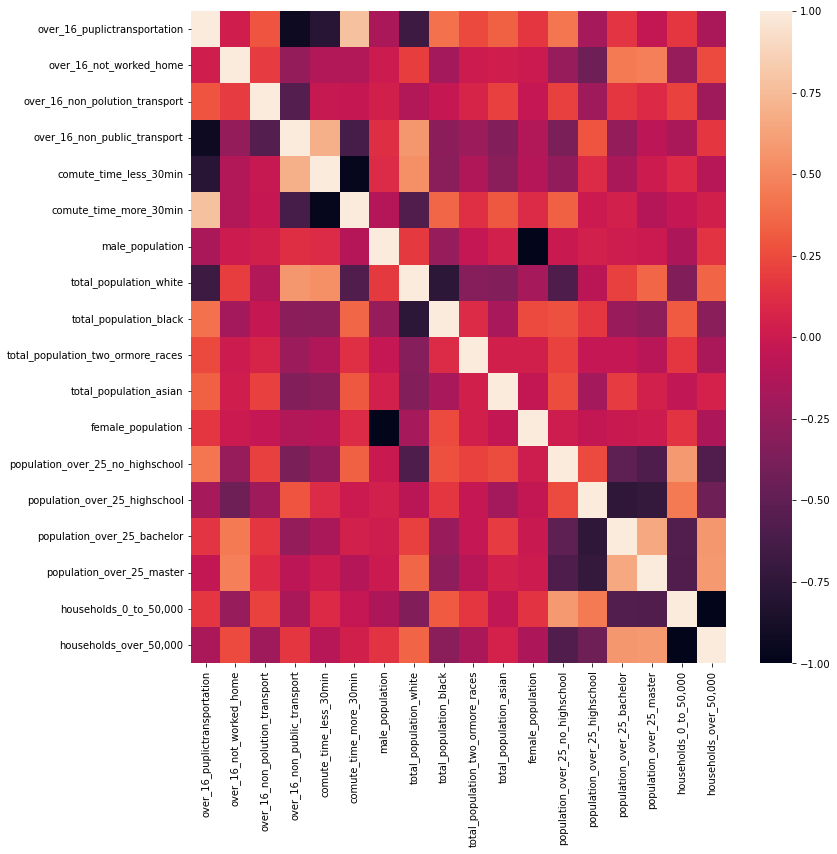

In [40]:
fig, ax = plt.subplots(1, figsize=(12,12))
corr = combined[normalized_cols].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [41]:
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


<AxesSubplot:>

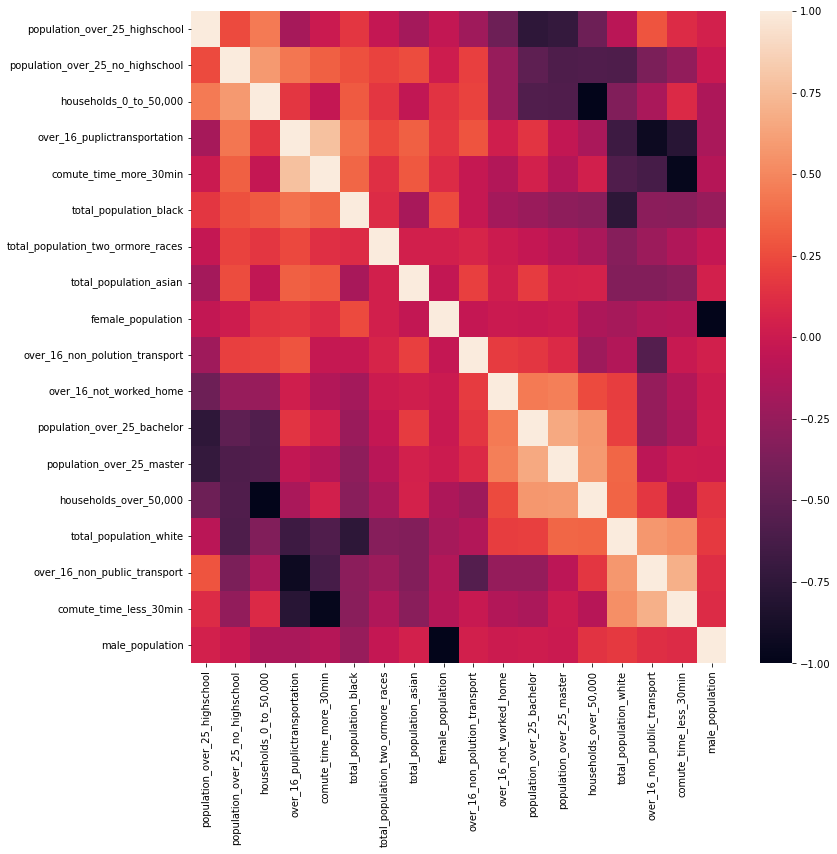

In [42]:
fig, ax = plt.subplots(1, figsize=(12,12))

sns.heatmap(cluster_corr(combined[normalized_cols].corr()))


In [43]:
combined = combined.to_crs("EPSG:4326")
combined.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Loading the stops


In [44]:
def get_stop_id(stop_id):
    """ translate stop_id to parent_stop_id 
        if available
    """
    if 'parent_station' not in STOPS[stop_id].keys():
        return stop_id
    elif STOPS[stop_id]['parent_station'] == '' or np.isnan(STOPS[stop_id]['parent_station']):
        return stop_id
    else:
        return STOPS[stop_id]['parent_station']


def add_stop_to_graph(G, stop_id):
    """ add stop as new node to graph
    """
    #lookup details of the stop (parent stop if available)
    node = STOPS[get_stop_id(stop_id)]

    if node['stop_id'] not in G.nodes:
        G.add_node(node['stop_id'], 
                   stop_name = node['stop_name'], 
                   stop_lon = node['stop_lon'], 
                   stop_lat = node['stop_lat'])
    return G

def add_edge_to_graph(G, from_id, to_id, route_short_name):
    """ add edge to graph 
        adding the route short name as a key
        if the edge and key exist, increment the count
    """
    edge = G.get_edge_data(get_stop_id(from_id), get_stop_id(to_id),route_short_name, default = 0)
    if edge == 0:
        G.add_edge(get_stop_id(from_id), get_stop_id(to_id), 
                   key=route_short_name,
                   count=1)
    else:
        G.add_edge(get_stop_id(from_id), get_stop_id(to_id), 
                   key=route_short_name,
                   count=edge['count']+1)
        
def get_stops_from_gtfs(path):
    feed = (gk.read_feed(path, dist_units='km'))
    return feed

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

In [48]:
DATA_ROOT='nyc/gtfs_zips/nyc_ferry.zip'
TRIPS_FILE = f'{DATA_ROOT}trips.txt'
ROUTES_FILE = f'{DATA_ROOT}routes.txt'
STOPS_FILE = f'{DATA_ROOT}stops.txt'

INCLUDE_AGENCIES=['MTA NYCT']
IGNORE_ROUTE=[]


# put all gtfs zips in one directory

# assign directory
directory = 'nyc/gtfs_zips/'
files = gk.list_feed(directory)
files=files[files['file_name'].str.contains('.zip')]['file_name']
files = directory+files

In [49]:
files

0         nyc/gtfs_zips/mta_brooklyn_gtfs.zip
1            nyc/gtfs_zips/mta_bronx_gtfs.zip
2        nyc/gtfs_zips/mta_manhattan_gtfs.zip
3               nyc/gtfs_zips/subway_gtfs.zip
4           nyc/gtfs_zips/mta_queens_gtfs.zip
5                 nyc/gtfs_zips/nyc_ferry.zip
6      nyc/gtfs_zips/long_island_railroad.zip
7    nyc/gtfs_zips/mta_staten_island_gtfs.zip
8          nyc/gtfs_zips/metro_north_gtfs.zip
Name: file_name, dtype: object

In [ ]:
def generate_all_dfs(files):
    feed = (gk.read_feed(files[0], dist_units='km'))
    
    for i in range(1,len(files)):
        feed = (gk.read_feed(DATA_ROOT, dist_units='km'))

In [ ]:
def generate_sub_gtfs_dfs(feed):
    STOPS = feed.get_stops().set_index('stop_id').to_dict('index')

    for key in STOPS.keys():
        STOPS[key]['stop_id'] = key
        
    ROUTES = feed.get_routes().set_index('route_id').to_dict('index')

    for key in ROUTES.keys():
        ROUTES[key]['route_id'] = key

    TRIPS = feed.get_trips().set_index('trip_id').to_dict('index')

    for key in TRIPS.keys():
        TRIPS[key]['route_short_name'] = ROUTES[TRIPS[key]['route_id']]['route_short_name']
        TRIPS[key]['trip_id'] = key
        
    stop_times = feed.get_stop_times()

In [51]:
feed = (gk.read_feed(DATA_ROOT, dist_units='km'))

STOPS = feed.get_stops().set_index('stop_id').to_dict('index')

for key in STOPS.keys():
    STOPS[key]['stop_id'] = key

In [52]:
ROUTES = feed.get_routes().set_index('route_id').to_dict('index')

for key in ROUTES.keys():
    ROUTES[key]['route_id'] = key

In [53]:
TRIPS = feed.get_trips().set_index('trip_id').to_dict('index')

for key in TRIPS.keys():
    TRIPS[key]['route_short_name'] = ROUTES[TRIPS[key]['route_id']]['route_short_name']
    TRIPS[key]['trip_id'] = key

In [54]:
stop_times = feed.get_stop_times()

In [55]:
# sort just to be sure
sorted_stops = feed.get_stop_times().sort_values(['trip_id', 'stop_sequence'], ascending=[True, True])

In [56]:
# rewrote using numpy array to increase speed significantly
trip_ids = sorted_stops['trip_id'].to_numpy()
stops_ids = sorted_stops['stop_id'].to_numpy()

In [59]:
stops = set()
edges = dict()

# build network
next_trip = trip_ids[1]
for i in tqdm(range(len(stops_ids)-1)):
    if trip_ids[i] in TRIPS:
        trip = TRIPS[trip_ids[i]]
        # if we are still on the same route, create edges
        if trip_ids[i]==next_trip:
            stop = stops_ids[i]
            stops.add(stop)
            next_stop = stops_ids[i+1]
            edge = (stop, next_stop)
            edges[edge] = trip['route_short_name']
        # we start a new route
        else:
            stop = stops_ids[i]
            stops.add(stop)
        
        if i < len(stops_ids)-2:
            next_trip=trip_ids[i+2]
        else:
            next_trip = -1
        
# add the final stop to the list
stops.add(next_stop)

100%|███████████████████████████████████| 3849/3849 [00:00<00:00, 382483.80it/s]


In [60]:
G = nx.MultiGraph()

In [61]:
print ('stops', len(stops))
print ('edges', len(edges))

for stop_id in STOPS:
    if stop_id in stops:
        add_stop_to_graph(G, stop_id)
        
print('Nodes:', G.number_of_nodes() )
        
for (start_stop_id, end_stop_id), route_short_name in edges.items():
    if start_stop_id==end_stop_id:
        print(start_stop_id, end_stop_id, route_short_name)
    add_edge_to_graph(G, 
                      from_id = start_stop_id, 
                      to_id = end_stop_id, 
                      route_short_name=route_short_name)
print('Edges:', G.number_of_edges() )



deg = nx.degree(G)
labels = {stop_id: G.nodes[stop_id]['stop_name'] if deg[stop_id] >= 0 else ''
          for stop_id in G.nodes}

pos = {stop_id: (G.nodes[stop_id]['stop_lon'], G.nodes[stop_id]['stop_lat'])
       for stop_id in G.nodes}

stops 52
edges 84
Nodes: 52
Edges: 58


In [62]:
G_simple = nx.Graph(G)

In [63]:
btw = nx.betweenness_centrality(G_simple)

In [64]:
# create scaled betweenness dictionary

l=np.zeros(len(btw))
keys=list(btw.keys())

for i in range(len(btw)):
    l[i]=btw[keys[i]]
    
# linear scale factor for betweenness
scale = (9/np.max(l))

for key in btw.keys():
    btw[key] = (btw[key]*scale)+1

In [65]:
nx.set_node_attributes(G_simple, btw, "betweenness")

In [66]:
# wrangle betweenness to df with coordinates
df_btw = pd.DataFrame.from_dict(btw, orient='index')
df_btw.columns=['betweenness']

betweenness_geo = df_btw.join(pd.DataFrame.from_dict(pos, orient='index'))
betweenness_geo.columns = ['betweenness','lon','lat']

In [67]:
# using number of departures as a frequency proxy 
betweenness_geo = betweenness_geo.join(
    stop_times['stop_id'].value_counts()).rename(
    columns={'stop_id':'num_departures'})

# arbitrarily set the scale to be 2.5,  This says frequency is about 25% as important as betweenness
scale = (2.5/betweenness_geo['num_departures'].max())

betweenness_geo['num_departures_scaled'] = (betweenness_geo['num_departures']*scale)+1

In [68]:
# FIND LIT FOR THIS, ARBITRARY FUNCTION
# create accessibility score
betweenness_geo['accessibility_score'] = \
    betweenness_geo['num_departures_scaled']+betweenness_geo['betweenness']

<AxesSubplot:xlabel='betweenness', ylabel='num_departures_scaled'>

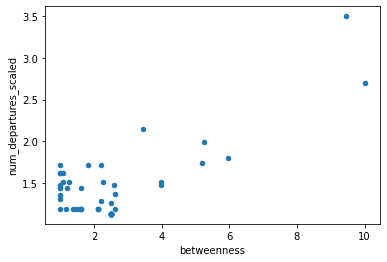

In [69]:
betweenness_geo.plot.scatter(x='betweenness',y='num_departures_scaled')

In [71]:
# we need to get route type for each stop to do the k-ring calc
temp_r = pd.DataFrame.from_dict(ROUTES, orient='index')[['route_type','route_id']]
temp_r = pd.DataFrame.from_dict(TRIPS, orient='index')[['route_id','trip_id']].merge(temp_r, on='route_id')
stop_times = stop_times.merge(temp_r, on='trip_id')

In [72]:
betweenness_geo = betweenness_geo.join(stop_times[['stop_id','route_type']].set_index('stop_id'))

In [87]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)
metric_col = 'accessibility_score'

# find hexs containing the points
betweenness_geo[hex_col] = betweenness_geo.apply(lambda x: h3.geo_to_h3(x.lat,x.lon,APERTURE_SIZE),1)

# sum accessibility grouped by route type and hex
hex_df = pd.DataFrame(
    betweenness_geo.groupby([hex_col,'route_type'])[metric_col].agg('sum')).reset_index()

In [95]:
#find center of hex for visualization
hex_df['stop_lat'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
hex_df['stop_lon'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [96]:
mapping={ # h3_resolution: {transport type : num_k_rings}
    8:{1:2, 2:2, 3:1, 4:2},
    9:{1:5, 2:5, 3:3, 4:5},
    10:{1:12, 2:12, 3:7, 4:12}
}

In [97]:
k_ring_all_types = pd.DataFrame(columns=[hex_col, 'accessibility_score', 'lat','lon'])                            
grouped_hex = hex_df.groupby('route_type')
for key, value in grouped_hex: 
    k_ring_all_types = pd.concat([k_ring_all_types,
        kring_smoothing(value, hex_col, metric_col=metric_col, k=mapping[APERTURE_SIZE][key])])

In [98]:
# sum all layers of smoothed route types
k_ring_all_types = k_ring_all_types.groupby([hex_col])['accessibility_score'].agg('sum').reset_index()
#find center of hex for visualization
k_ring_all_types['lat'] = k_ring_all_types[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
k_ring_all_types['lon'] = k_ring_all_types[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

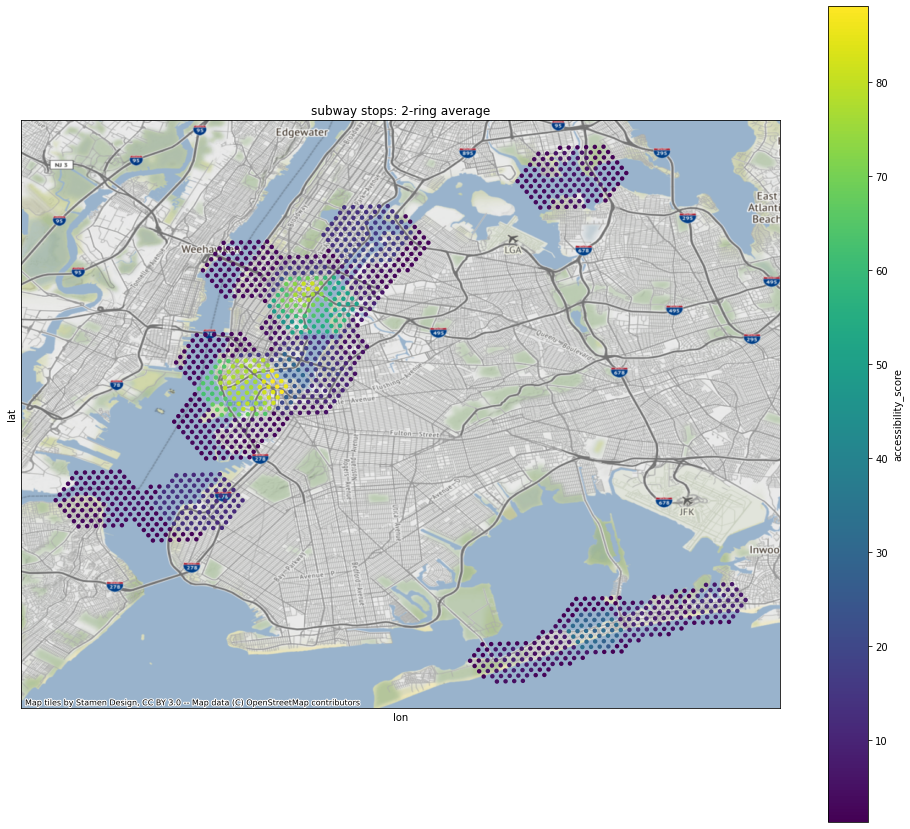

In [99]:
fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
k_ring_all_types.plot.scatter(ax=ax, x='lon', y='lat', c=metric_col,
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway stops: 2-ring average');

ctx.add_basemap(ax=ax, crs="EPSG:4326")

## Spatial analysis

In [101]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()
gdf = gdf.to_crs("EPSG:4326")

METRIC_COL = "over_16_non_public_transport"
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

In [103]:
sgdf = gpd.GeoDataFrame(hex_df, geometry=gpd.points_from_xy(hex_df.stop_lon, hex_df.stop_lat), crs=gdf.crs)
sgdf.head()

,hex9,route_type,accessibility_score,stop_lat,stop_lon,geometry
0,892a100195bffff,4,203.093023,40.806713,-73.837971,POINT (-73.83797 40.80671)
1,892a1001b8fffff,4,332.726305,40.803794,-73.848577,POINT (-73.84858 40.80379)
2,892a10089b7ffff,4,1229.410005,40.777487,-73.943980,POINT (-73.94398 40.77749)
3,892a100d00bffff,4,330.534884,40.742634,-73.961904,POINT (-73.96190 40.74263)
4,892a100d04bffff,3,165.154119,40.744988,-73.972694,POINT (-73.97269 40.74499)


In [105]:
accessibility_metric = "accessibility_score"
gdf = sgdf[[accessibility_metric, "geometry"]].sjoin(gdf, how="right", predicate='intersects').drop(columns=["index_left"]).fillna(0)



In [106]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2220 entries, 0 to 5410
Columns: 110 entries, accessibility_score to over_16_non_public_transport
dtypes: float64(19), geometry(1), int64(65), object(25)
memory usage: 1.9+ MB


In [107]:
gdf.head().T

,0,1,2,3,4
accessibility_score,0.0,0.0,0.0,0.0,0.0
STATEFP,36,36,36,36,36
COUNTYFP,047,047,047,047,047
TRACTCE,000700,000900,001100,001300,002000
GEOID,36047000700,36047000900,36047001100,36047001300,36047002000
...,...,...,...,...,...
comute_time_more_30min,0.581161,0.428086,0.50084,0.481289,0.731261
over_16_puplictransportation,0.672611,0.651852,0.668067,0.5,0.606947
over_16_not_worked_home,0.138546,0.189198,0.126891,0.22973,0.0
over_16_non_polution_transport,0.137631,0.128395,0.07395,0.179834,0.268739


## Modelling

In [108]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [109]:
gdf.columns

Index(['accessibility_score', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID',
       'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       ...
       'population_over_25_master', 'households', 'households_0_to_50,000',
       'households_over_50,000', 'comute_time_less_30min',
       'comute_time_more_30min', 'over_16_puplictransportation',
       'over_16_not_worked_home', 'over_16_non_polution_transport',
       'over_16_non_public_transport'],
      dtype='object', length=110)

In [111]:
feature_col = [accessibility_metric, 'Average Commute to Work (In Min)',
       'over_16_puplictransportation', 'over_16_not_worked_home',
       'over_16_non_polution_transport', 'over_16_non_public_transport',
       'comute_time_less_30min', 'comute_time_more_30min', 'male_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000']
target_col = 'over_16_puplictransportation'
feature_col = np.array([col for col in feature_col if col not in [target_col]])

In [112]:
regression_df = gdf[feature_col.tolist()+[target_col]].copy()
#regression_df['Average Commute to Work (In Min)'] = regression_df['Average Commute to Work (In Min)'].fillna("0").astype(float)

In [113]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2220 entries, 0 to 5410
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   accessibility_score                2220 non-null   float64
 1   Average Commute to Work (In Min)   2220 non-null   object 
 2   over_16_not_worked_home            2220 non-null   float64
 3   over_16_non_polution_transport     2220 non-null   float64
 4   over_16_non_public_transport       2220 non-null   float64
 5   comute_time_less_30min             2220 non-null   float64
 6   comute_time_more_30min             2220 non-null   float64
 7   male_population                    2220 non-null   float64
 8   total_population_white             2220 non-null   float64
 9   total_population_black             2220 non-null   float64
 10  total_population_two_ormore_races  2220 non-null   float64
 11  total_population_asian             2220 non-null   float

<AxesSubplot:>

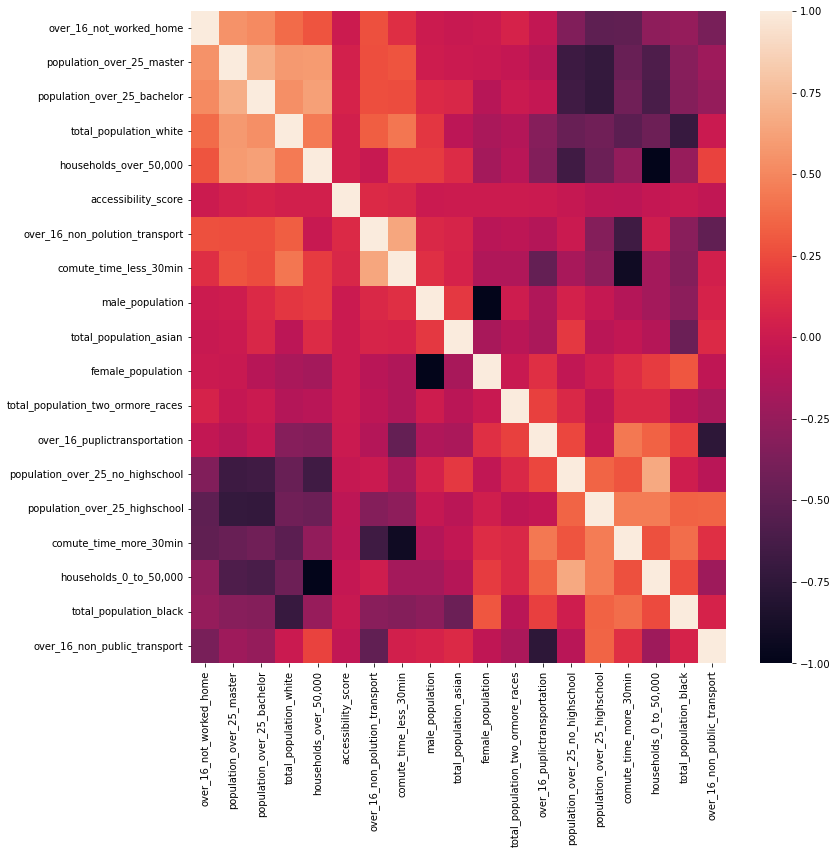

In [114]:
fig, ax = plt.subplots(1, figsize=(12,12))

sns.heatmap(cluster_corr(regression_df.corr()))

In [115]:
kf = KFold(n_splits=5)

X = regression_df[feature_col]
y = regression_df[target_col].values

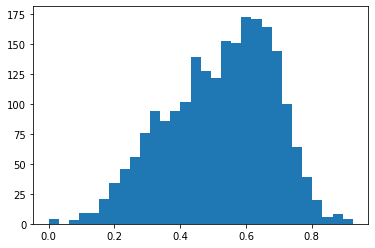

0.5220368704049232 0.16138853450615812


In [116]:
plt.hist(y, bins=30)
plt.show()
print(np.array(y).mean(),np.array(y).std())

In [117]:
feature_col

array(['accessibility_score', 'Average Commute to Work (In Min)',
       'over_16_not_worked_home', 'over_16_non_polution_transport',
       'over_16_non_public_transport', 'comute_time_less_30min',
       'comute_time_more_30min', 'male_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000'], dtype='<U33')

In [118]:
X.head()

,accessibility_score,Average Commute to Work (In Min),over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport,comute_time_less_30min,comute_time_more_30min,male_population,total_population_white,total_population_black,total_population_two_ormore_races,total_population_asian,female_population,population_over_25_no_highschool,population_over_25_highschool,population_over_25_bachelor,population_over_25_master,"households_0_to_50,000","households_over_50,000"
0,0.0,36,0.138546,0.137631,0.102423,0.280293,0.581161,0.498846,0.847140,0.025391,0.089254,0.023083,0.501154,0.024372,0.050564,0.415424,0.264824,0.158179,0.841821
1,0.0,29,0.189198,0.128395,0.053086,0.382716,0.428086,0.485174,0.771594,0.038032,0.084658,0.100774,0.514826,0.023425,0.025848,0.439688,0.272213,0.071804,0.928196
2,0.0,32,0.126891,0.073950,0.178992,0.372269,0.500840,0.618509,0.701065,0.083222,0.037949,0.152463,0.381491,0.008600,0.046912,0.454261,0.261142,0.110024,0.889976
3,0.0,30,0.229730,0.179834,0.180873,0.288981,0.481289,0.518519,0.664058,0.104851,0.061033,0.127804,0.481481,0.013977,0.121982,0.245870,0.343075,0.287953,0.712047
4,0.0,39,0.000000,0.268739,0.248629,0.268739,0.731261,0.480373,0.406520,0.027279,0.007319,0.060546,0.519627,0.520651,0.272841,0.162703,0.000000,0.577320,0.422680


In [119]:
preds = np.zeros(len(y))
coefs = np.zeros(len(X.columns))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5

In [120]:
idx = np.argsort(coefs)

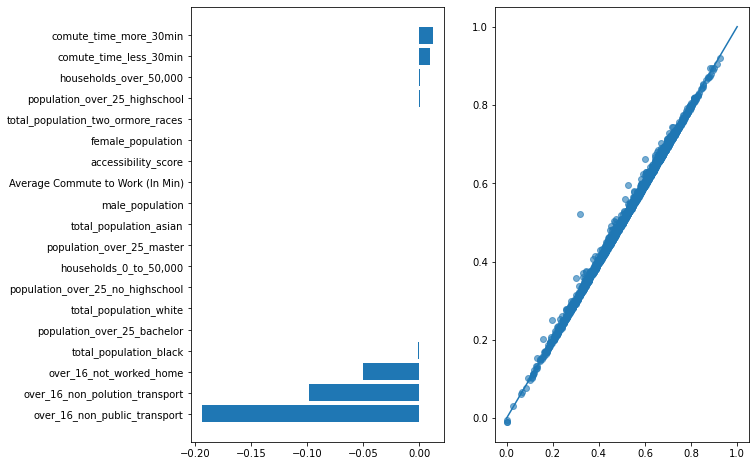

(0.008041780738311098, 0.9975171007372247)

In [121]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].barh(feature_col[idx],coefs[idx])

ax[1].scatter(y, preds, alpha=0.6)
ax[1].plot([i for i in range(2)])
plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

In [123]:
feature_col =  np.array([col for col in feature_col if col not in ['over_16_non_public_transport', 'over_16_non_polution_transport']])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


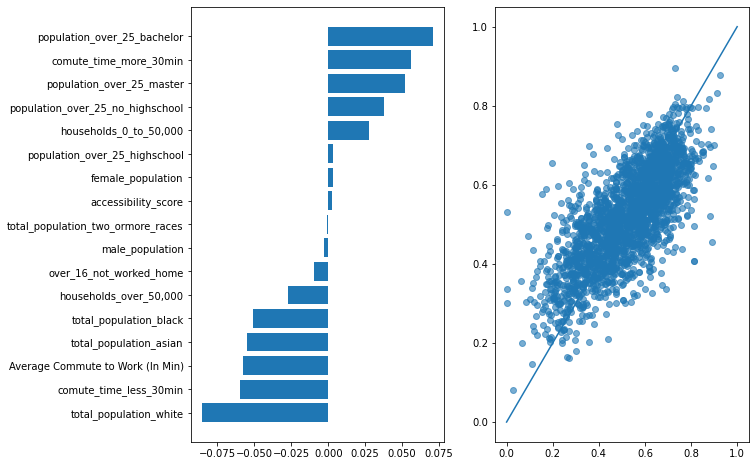

(0.10814090690244803, 0.5510120776179642)

In [124]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)
ax[0].barh(feature_col[idx],coefs[idx])

ax[1].scatter(y, preds, alpha=0.6)
ax[1].plot([i for i in range(2)])
plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

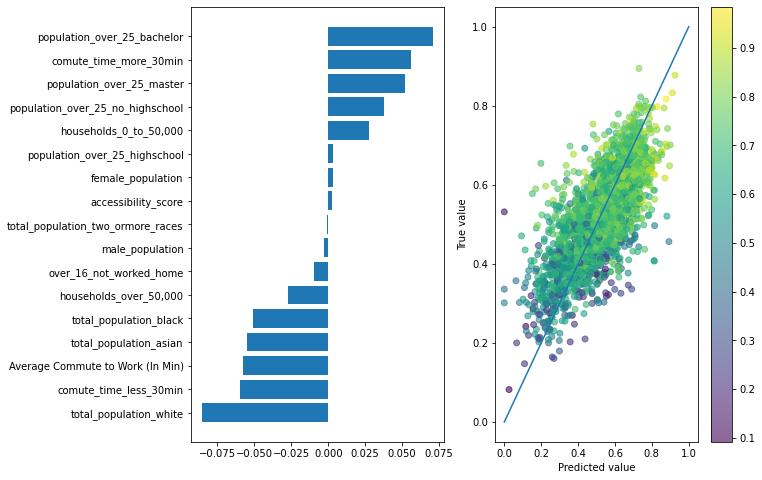

(0.10814090690244803, 0.5510120776179642)

In [125]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].barh(feature_col[idx],coefs[idx])

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df["comute_time_more_30min"])
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1])

plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

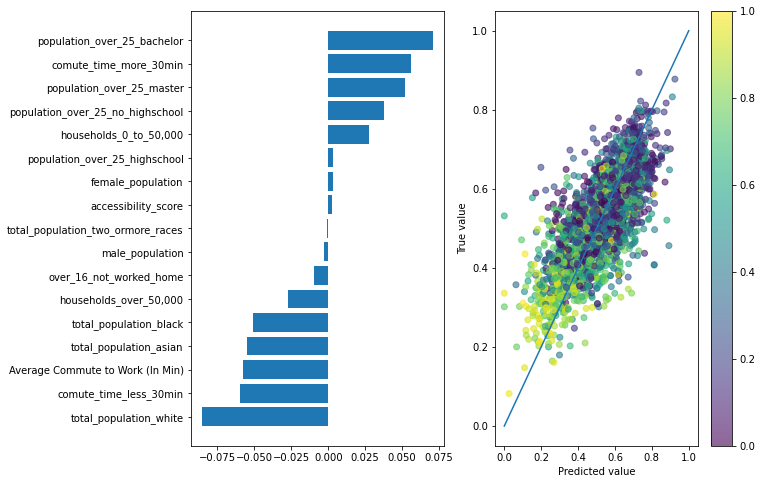

(0.10814090690244803, 0.5510120776179642)

In [126]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)
ax[0].barh(np.array(feature_col)[idx],coefs[idx])

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df["total_population_white"])
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1])

plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

In [127]:
feature_col =  np.array([col for col in feature_col if col not in ['over_16_non_public_transport', "comute_time_more_30min"]])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


In [128]:
feature_col

array(['accessibility_score', 'Average Commute to Work (In Min)',
       'over_16_not_worked_home', 'comute_time_less_30min',
       'male_population', 'total_population_white',
       'total_population_black', 'total_population_two_ormore_races',
       'total_population_asian', 'female_population',
       'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000'], dtype='<U33')

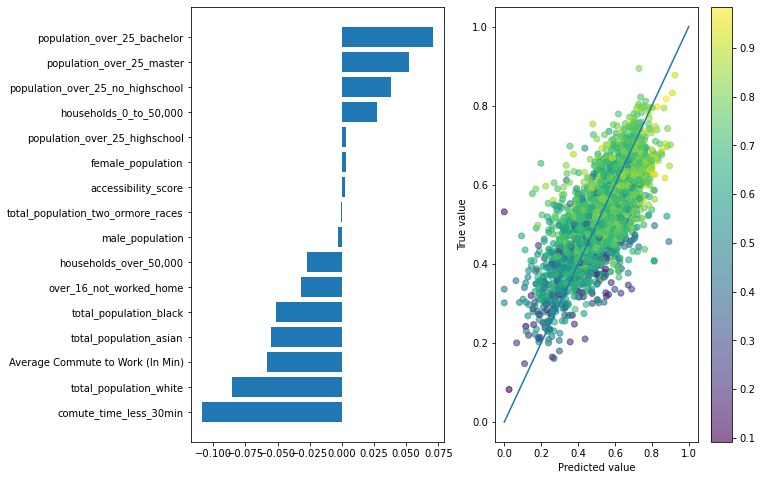

(0.10814124116093454, 0.5510093020123283)

In [129]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)

ax[0].barh(feature_col[idx],coefs[idx])

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df["comute_time_more_30min"])
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1])

plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

# Visualizing the results

In [130]:
#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis', basemap=None, ax=None):  
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df.plot.scatter(ax=ax, x=x, y=y, c="white", title=metric_col
                    , edgecolors='none', marker=marker, alpha=alpha, figsize=figsize);
    if basemap:
        ctx.add_basemap(ax=ax, crs=basemap)

    plt.xticks([], []); plt.yticks([], [])
    return ax
    

Text(0.5, 1.0, 'Prediction error')

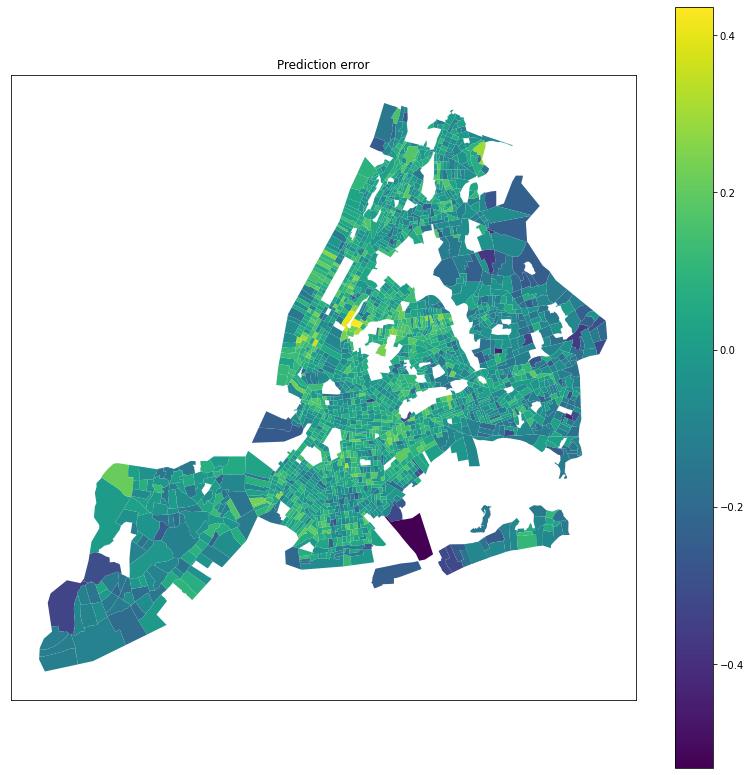

In [132]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(14,14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax = plot_scatter(stopsg, metric_col='cnt', y="stop_lat", x="stop_lon", marker='o', basemap=gdf.crs.to_string(),ax=ax)
gdf["Prediction_diff"] = y - preds
ax = gdf.plot(column="Prediction_diff",cmap='viridis',alpha=1,linewidth=0.05,ax=ax, legend=True)
#ax = stopsg.plot.scatter(ax=ax, y="stop_lat", x="stop_lon", marker="o", color="white", alpha=.5, edgecolors='none')

plt.title('Prediction error')